# Homework3: Normalizing flows

## Task 1: Theory (5pt)

### Problem 1: Sylvester flow (2pt)

At the Seminar 5, we have studied planar flows of the form:
$$
    \mathbf{x} = g(\mathbf{z}, \boldsymbol{\theta}) = \mathbf{z} + \mathbf{u} h(\mathbf{w}^T\mathbf{z} + b),
$$
where $\mathbf{u} \in \mathbb{R}^m$,  $\mathbf{w} \in \mathbb{R}^m$, $b \in \mathbb{R}$.

There is a natural generalization of planar flows of the form:
$$
   \mathbf{x} = g(\mathbf{z}, \boldsymbol{\theta}) = \mathbf{z} + \mathbf{V} h(\mathbf{W}^T\mathbf{z} + \mathbf{b}),
$$
where $\boldsymbol{\theta} = \{\mathbf{V}, \mathbf{W}, \mathbf{b}\}$, $\mathbf{V} \in \mathbb{R}^{m \times k}$,  $\mathbf{W} \in \mathbb{R}^{m \times k}$, $\mathbf{b} \in \mathbb{R}^k$, $h : \mathbb{R}^k \rightarrow \mathbb{R}$ is nonlinear function, which applied pointwise to the elements of the vector $\mathbf{W}^T\mathbf{z} + \mathbf{b}$. This flow is called [Sylvester flow](https://arxiv.org/abs/1803.05649).

1. Prove a simplified version of the matrix-determinant lemma:
$$
    \det (\mathbf{I}_m + \mathbf{V} \mathbf{W}^T) = \det (\mathbf{I}_k + \mathbf{W}^T \mathbf{V}).
$$

2. Calculate the determinant of the Jacobi matrix for the Sylvester flow  and apply the lemma proved in the previous paragraph to it.

3. In order to reduce the complexity for the determinant calculation (and ensure the invertibility of the transform $g(\mathbf{z}, \boldsymbol{\theta})$), the authors proposed to parametrize the matrices $\mathbf{V}$ and $\mathbf{W}$ as follows:
$$
    \mathbf{V} = \mathbf{Q} \mathbf{U}; \quad \mathbf{W} = \mathbf{Q} \mathbf{L},
$$
where $\mathbf{Q} \in \mathbb{R}^{m \times k}$ — orthogonal matrix ($\mathbf{Q}^T \mathbf{Q} = \mathbf{I}$), $\mathbf{U} \in \mathbb{R}^{k \times k}$ — upper triangular matrix, $\mathbf{L} \in \mathbb{R}^{k \times k}$ — lower triangular matrix ([wiki](https://en.wikipedia.org/wiki/Triangular_matrix)). Write out an expression for the Jacobian determinant using this parametrization.
4) Calculate and compare the complexity for calculating the determinant of the Jacobi matrix
   * before applying the lemma;
   * after applying the lemma;
   * after applying the $\mathbf{Q} \mathbf{U}$, $\mathbf{Q} \mathbf{L}$ parametrization.


```your solution```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

In [ ]:
m = 5
k = 10

V = torch.randn(m, k)
W = torch.randn(m, k)
b = torch.randn(k)
print(V.shape, W.shape, b.shape)

print(torch.det(torch.eye(m) + V @ W.T))
print(torch.det(torch.eye(k) + W.T @ V))

torch.Size([5, 10]) torch.Size([5, 10]) torch.Size([10])
tensor(645.6318)
tensor(645.6321)


In [ ]:
m = 5
k = 10

x = torch.randn(m)
V = torch.randn(m, k)
W = torch.randn(m, k)
b = torch.randn(k)

j_x1 = torch.det(torch.eye(m) + torch.matmul(torch.matmul(V, torch.diag(torch.sigmoid(torch.matmul(W.T, x) + b))), W.T))
j_x2 = torch.det(torch.eye(k) + torch.matmul(torch.diag(torch.sigmoid(torch.matmul(W.T, x) + b)), torch.matmul(W.T, V)))
print(j_x1, j_x2)

tensor(-6.5219) tensor(-6.5219)


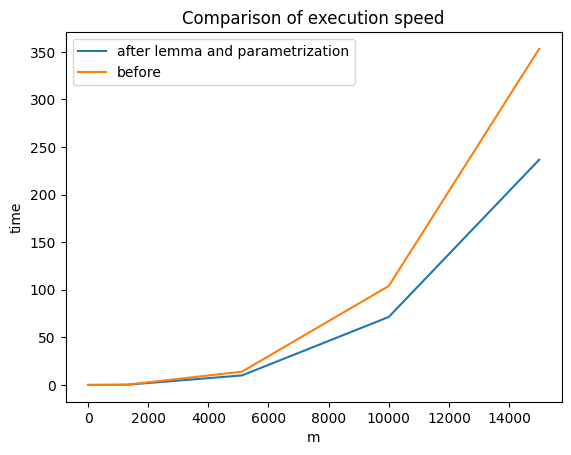

In [ ]:
import time

def det_J(i):
  m = i
  k = m

  x = torch.randn(m)
  A = torch.randn(m, k)
  U = torch.randn(k, k)
  L = torch.randn(k, k)
  U.triu_(diagonal=1)
  L.tril_(diagonal=-1)
  U.diagonal().uniform_(0.1, 0.9)
  L.diagonal().uniform_(0.1, 0.9)
  activ = torch.sigmoid

  b = torch.randn(k)

  Q = torch.empty(m, k)
  nn.init.orthogonal_(Q)

  V = Q @ U
  W = Q @ L
  start = time.time()
  j_1 = torch.det(torch.eye(k) + torch.diag(activ(W.T @ x + b)) @ (L.T @ U))
  time1 = time.time() - start
  start2 = time.time()
  j_2 = torch.det(torch.eye(m) + V @ torch.diag(activ(W.T @ x + b)) @ W.T)
  time2 = time.time() - start2
  return time1, time2

time1 = []
time2 = []
arr_m = [5, 20, 80, 320, 1280, 5120, 10000, 15000]
for m in arr_m:
  t_1, t_2 = det_J(m)
  time1.append(t_1)
  time2.append(t_2)

plt.plot(arr_m, time1, label="after lemma and parametrization")
plt.plot(arr_m, time2, label="before")

plt.xlabel("m")  # Подпись оси X
plt.ylabel("time")   # Подпись оси Y
plt.title("Comparison of execution speed")  # Заголовок графика
plt.legend()

plt.show()

### Problem 2: Expressivity of normalizing flows (2pt)

Let $\pi(\mathbf{x})$ is an absolutely continuous probability distribution supported everywhere on $\mathbb{R}^m$ (i.e. $\pi(\mathbf{x}) > 0$ for all $\mathbf{x} \in \mathbb{R}^m$). Additionally we suppose, that the pdf $\pi(\mathbf{x})$ is continuously differentiable on  $\mathbb{R}^m$.  Our ultimate goal is to show, that there exists diffeomorphism (invertible continuously differentiable map):
$$
    \mathbf{u} = F(\mathbf{x}) \quad F : \mathbb{R}^m \rightarrow \mathbb{U}.
$$
Here $\mathbb{U} = [0, 1]^m$ is a hypercube, which turns $\pi(\mathbf{x})$ into uniform distribution $p(\mathbf{u}) = U[0, 1]^m$ on the hypercube $\mathbb{U}$ ($p(\mathbf{u}) = 1 \,,\, \mathbf{u} \in \mathbb{U}$). Here we have to think about openness and closeness of $\mathbb{U}$ for formal math correctness, but we omit it in this task. <sub><sup><i>Math correctness comment</i>: Strictly speaking, the diffeomorphism $F$ maps $\mathbb{R}^m$ to the open cube $\text{int}\left(\mathbb{U}\right) = (0, 1)^m$, sinse the reverse mapping $F^{-1} : \text{int}\left(\mathbb{U}\right) \rightarrow \mathbb{R}^m$ is continuous $\Rightarrow$ the preimage of the open set $\mathbb{R}^m$ with respect to $F^{-1}$ should be <b>open</b>: $(F^{-1})^{-1}(\mathbb{R}^m) = F(\mathbb{R}^m) = \text{an open set}$</sup></sub>

If such function exists, it means that **there exists normalizing flow model from base uniform distribution to any(!) target distribution.**

---------

1. Consider the autoregressive decomposition of $\pi(\mathbf{x})$:

$$
    \pi(\mathbf{x}) = \prod\limits_{j = 1}^{m} \pi(x_j|\mathbf{x}_{1:j - 1}).
$$

2. Treat each component $\pi(x_j|\mathbf{x}_{1:j - 1})$ in the decomposition above separately. Consider the transformations:

$$
    \mathbf{x} \rightarrow u_j = F_j(x_j, \mathbf{x}_{1:j - 1}) = \int\limits_{- \infty}^{x_j} \pi(x_j'|\mathbf{x}_{1:j - 1}) d x_j'.
$$

   Here $F_j(x_j, \mathbf{x}_{1:j - 1})$ is the cumulative distribution function of $j$-th conditional $x_j$ (given $\mathbf{x}_{1:j - 1}$) Note, that $u_j \in [0, 1]$.

3. Define the transform $F : \mathbb{R}^m \rightarrow \mathbb{U}$ as follows:
    
$$
    \mathbf{x} \rightarrow \mathbf{u} = \begin{bmatrix} F_1(x_1) \\ F_2(x_2,x_1) \\ \dots \\ F_m(x_m, \mathbf{x}_{1:m-1})\end{bmatrix}.
$$
    
Given the properties of $\pi$ ($\pi(\mathbf{x}) > 0$ and continuously differentiable) it is easy to show, that $F$ is continuously differentiable. We omit the details since they are just boring mathematical calculations.

**Subproblem 2.1 (1pt):** Prove, that $\det \mathbf{J}_F (\mathbf{x}) = \pi(x)$ (it follows, that the function $F : \mathbb{R}^m \rightarrow \mathbb{U}$ is invertible).

**Subproblem 2.2 (0.5pt):** Prove, that $\mathbf{u}$ is a uniformly distributed ($p(\mathbf{u}) = U[0,1]^m)$.

**Subproblem 2.3 (0.5pt):** Let $\pi(\mathbf{x})$ and $\mu(\mathbf{y})$ are absolutely continuous probability distributions supported everywhere on $\mathbb{R}^m$, whose pdfs are continuously differentiable. Prove that there exists a diffeomorphism $G : \mathbb{R}^m \rightarrow \mathbb{R}^m$ which turns $\pi$ into $\mu$, i.e.:

$$\mathbf{y} = G(\mathbf{x}), \quad \text{where } \mathbf{x} \sim \pi(\mathbf{x}), \, \mathbf{y} \sim \mu(\mathbf{y}).$$

```your solution```

### Problem 3: Discrete vs continuous model (1pt)
Let's suppose we have 2 generative models for images of size $W \times H \times C$, where $W$ - image width, $H$ - image height, $C$ - number of channels.

* The first model $p_1(\mathbf{x} | \boldsymbol{\theta})$ outputs a discrete distribution for each pixel  $\text{Categorical}(\boldsymbol{\pi})$, где $\boldsymbol{\pi} = (\pi_1, \dots,  \pi_{256})$.

* The second model $p_2(\mathbf{x} | \boldsymbol{\theta})$ models a discrete distribution by a continuous mixture of logistic functions ($\boldsymbol{\pi}$ - mixing distribution):
$$
    P(x | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) = P(x + 0.5 | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) - P(x - 0.5 | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}).
$$

$$
    p(\nu | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) = \sum_{k=1}^K \pi_k p(\nu | \mu_k, s_k).
$$

Each of the models outputs parameters of pixel distributions.

* Calculate the dimensions of the output tensor for the model $p_1(\mathbf{x} | \boldsymbol{\theta})$ and for the model $p_2(\mathbf{x} | \boldsymbol{\theta})$.
* At what number of mixture components $K$ is the number of elements of the output tensor for $p_2(\mathbf{x} | \boldsymbol{\theta})$ becomes greater than $p_1(\mathbf{x} | \boldsymbol{\theta})$.

```your solution```

In [2]:
REPO_NAME = "2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Cloning into '2023-DGM-MIPT-course'...
remote: Enumerating objects: 1071, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 1071 (delta 146), reused 212 (delta 131), pack-reused 835 (from 1)
Receiving objects: 100% (1071/1071), 404.46 MiB | 29.81 MiB/s, done.
Resolving deltas: 100% (429/429), done.
Updating files: 100% (353/353), done.
Processing ./2023-DGM-MIPT-course/homeworks
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples, visualize_2d_densities
from dgm_utils import show_samples, visualize_images, load_dataset

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision

USE_CUDA = torch.cuda.is_available()

## Task 2: RealNVP on 2d data (3pt)

In this task you will implement [RealNVP](https://arxiv.org/abs/1605.08803) model on 2d moons dataset.


The following function generates the data (do not change it).

In [ ]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

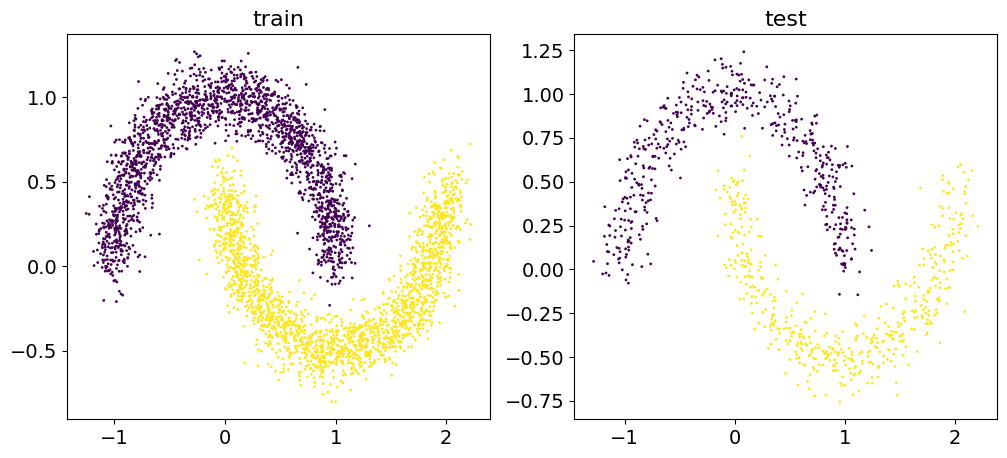

In [ ]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Our model will be a sequence of the affine coupling layers. Note that you have to permute the features that left unchanged between different layers (change order of $\mathbf{x}_1$ and $\mathbf{x}_2$ in the formulas below).

Forward transform:
$$
    \begin{cases}
        \mathbf{y}_1 &= \mathbf{x}_1; \\
        \mathbf{y}_2 &= \mathbf{x}_2 \odot \exp (s(\mathbf{x}_1)) + t(\mathbf{x}_1).
    \end{cases}
$$

Inverse transform:
$$
    \begin{cases}
        \mathbf{x}_1 &= \mathbf{y}_1; \\
        \mathbf{x}_2 &= (\mathbf{y}_2 - t(\mathbf{y}_1)) \odot \exp ( - s(\mathbf{y}_1)).
    \end{cases}
$$

Here $s(\cdot)$ and $t(\cdot)$ are outputs of neural network. In this task our networks will be fully connected MLP.

Let define the affine coupling layer.

In [ ]:
from re import M
class AffineCouplingLayer(nn.Module):
    def __init__(self, parity_type: bool, n_hiddens: list) -> None:
        assert isinstance(parity_type, bool)
        assert isinstance(n_hiddens, list)
        super().__init__()
        self.mask = self.build_mask(parity_type=parity_type)
        self.mlp = torchvision.ops.MLP(in_channels=2, hidden_channels=n_hiddens + [2])

    def build_mask(self, parity_type: bool) -> torch.Tensor:
        # ====
        # your code
        # the mask is extremely simple
        # it is a float tensor of two scalars (1.0 and 0.0)
        # the partition_type defines the order of these two scalars
        if parity_type:
          return torch.tensor([1.0, 0.0])
        else:
          return torch.tensor([0.0, 1.0])
        # ====

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        # ====
        # your code
        # 1) mask our input x, using self.mask
        # 2) apply mlp to masked input to get s and t
        mask = self.mask.to(x.device)
        # print("mask\n", mask)
        x_masked = x * mask
        # print("x_masked\n", x_masked)
        s, t = self.mlp(x_masked).chunk(2, dim=-1)
        # print("s, t\n", s, t)
        # ====

        # we invert mask here
        t = t * (1.0 - mask)
        s = s * (1.0 - mask)
        # print("s, t invert\n", s, t)

        # ====
        # your code
        # apply forward (invert=False) or inverse (invert=True) transform (invert=False)
        if not invert:
            # Forward transform
            z = x_masked + (1 - mask) * (x * torch.exp(s) + t)
            s = s.sum(dim=1)
        else:
            # Inverse transform
            z = x_masked + (1 - mask) * ((x - t) * torch.exp(-s))
            s = -s.sum(dim=1)
        # ====

        # the output is transformed input
        # and logarithm of jacobian (which equals to s)
        return z, s


def test_affine_coupling_layer():
    x = torch.zeros((4, 2), dtype=torch.float32).cuda()

    layer = AffineCouplingLayer(parity_type=True, n_hiddens=[4, 4]).cuda()
    mask = np.array([1, 0], dtype=np.float32)
    out1, out2 = layer(x)
    assert tuple(out1.size()) == (4, 2)
    assert tuple(out2.size()) == (4, 2)

    assert np.allclose(out1.cpu().detach().numpy()[0, 0] * mask, np.zeros((2, 2)))
    assert np.allclose(out2.cpu().detach().numpy()[0, 0], np.zeros((2, 2)))

    layer = AffineCouplingLayer(parity_type=False, n_hiddens=[4, 4]).cuda()
    mask = np.array([[0, 1]], dtype=np.float32)
    out1, out2 = layer(x)
    assert tuple(out1.size()) == (4, 2)
    assert tuple(out2.size()) == (4, 2)

    assert np.allclose(out1.cpu().detach().numpy() * mask, np.zeros((4, 2)))


# test_affine_coupling_layer()

We are ready to define RealNVP model. The model objective is the negative value of log-likelihood. Log-likelihood is given by the change of variables (CoV) theorem:
$$
	\log p(\mathbf{x}| \boldsymbol{\theta}) = \log p(\mathbf{z}) + \log \left|\det \left(  \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right) \right| = \log p(f(\mathbf{x}, \boldsymbol{\theta})) + \log \left|\det \left( \frac{\partial f(\mathbf{x}, \boldsymbol{\theta})}{\partial \mathbf{x}} \right) \right|.
$$

In [ ]:
class RealNVP(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # base distribution p(z) is normal
        self.prior = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))
        # ====
        # your code
        # apply sequence of AffineCouplingLayer with alternating parity_type
        # 6 layers is sufficient (with 2 hidden layers in each affine layer)
        self.transforms = nn.ModuleList([
            AffineCouplingLayer(parity_type=False, n_hiddens=[64, 64]),
            AffineCouplingLayer(parity_type=True, n_hiddens=[64, 64]),
            AffineCouplingLayer(parity_type=False, n_hiddens=[64, 64]),
            AffineCouplingLayer(parity_type=True, n_hiddens=[64, 64]),
            AffineCouplingLayer(parity_type=False, n_hiddens=[64, 64]),
            AffineCouplingLayer(parity_type=True, n_hiddens=[64, 64])
        ])
        # ====

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        z = x
        # log_det = 0.0
        log_det = torch.zeros(x.shape[0], device=self.device)

        # ====
        # your code
        # apply sequence of transforms and sum all of log_dets
        # if invert == True, you have to apply transforms in reversed order (from last to first!) with invert=True flag
        transforms = reversed(self.transforms) if invert else self.transforms

        for transform in transforms:
          z, s = transform(z, invert=invert)
          log_det += s
        return z, log_det

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) make forward pass with right inverse flag
        # 2) sum log_det with log of base distribution (log p(z)) - see the formula above
        # 3) we will get tensor of shape [batch_size, 2] - sum it over the the last dimension
        z, log_det = self.forward(x, invert=False)
        log_pz = self.prior.log_prob(z).sum(dim=1)
        log_px = log_pz + log_det
        return log_px
        # ====

    def loss(self, x: torch.Tensor) -> dict:
        log_prob = self.log_prob(x)
        # log_prob should be a vector of batch_size
        assert len(log_prob.shape) == 1
        return {"nll_loss": -log_prob.mean()}

    def sample(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # 1) sample from the prior
        # 2) apply the forward pass with the right inverse flag
        # 3) return only the first output of the forward pass (the second is the log of determinant - we don't need it in sampling)
        z = self.prior.sample((n, 2)).to(self.device)
        x, _ = self.forward(z, invert=True)
        return x
        # ====

It is time to train our model.

  0%|          | 0/100 [00:00<?, ?it/s]

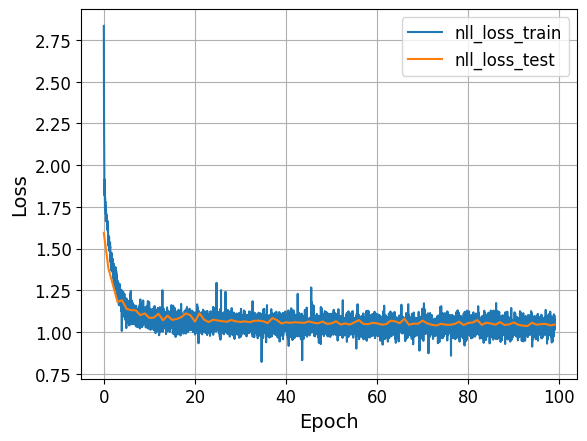

In [ ]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 512  # any adequate value
EPOCHS = 100      # < 100
LR = 1e-3          # < 1e-2
# ====

COUNT = 50000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)

loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = data.DataLoader(train_data, **loader_args)
test_loader = data.DataLoader(test_data, **loader_args)

# model
model = RealNVP()

# train
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key="nll_loss",
    use_cuda=USE_CUDA,
    use_tqdm=True,
)
plot_training_curves(train_losses, test_losses)

Let check visually that our model is correct.

Here we visualize:
* samples $\mathbf{x}$ from $p(\mathbf{x})$ - you have to get moons;
* the density $p(\mathbf{x})$ - you have to get moons;
* the points $\mathbf{z}$ from prior distribution $p(\mathbf{z})$ - it should be similar to standard normal.

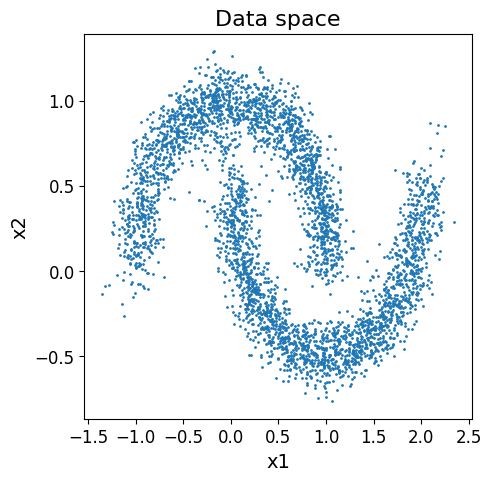

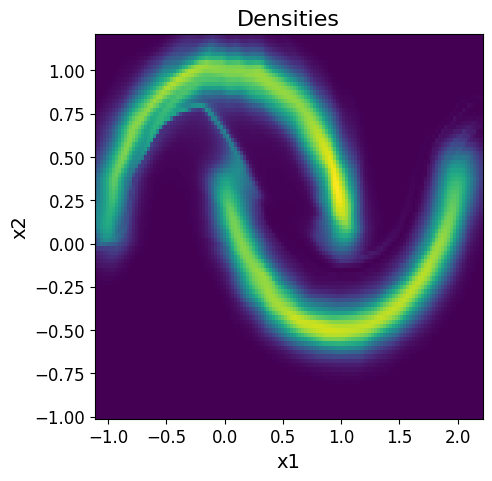

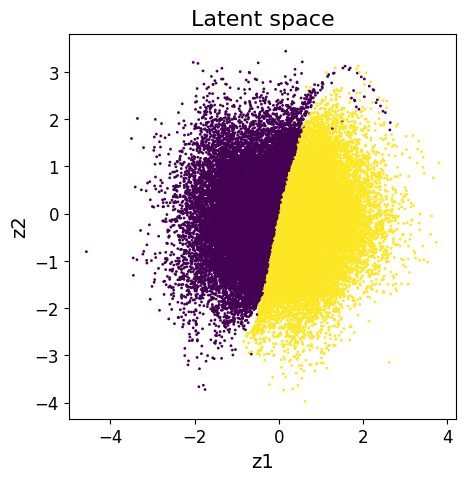

In [ ]:
# Samples

x_samples = model.sample(4000).cpu().detach().numpy()
visualize_2d_samples(x_samples, title="Data space", xlabel="x1", ylabel="x2")

# Density
dx, dy = 0.025, 0.025
x_lim = (-1.1, 2.2)
y_lim = (-1, 1.2)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy), slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
mesh_xs = mesh_xs.to('cuda')

densities = np.exp(model.log_prob(mesh_xs).cpu().detach().numpy())

# Latents
train_tensor = torch.FloatTensor(train_data)
train_tensor = train_tensor.to('cuda')
z = model(train_tensor)[0]
latents = z.cpu().detach().numpy()

visualize_2d_densities(x, y, densities, title="Densities", xlabel="x1", ylabel="x2")
visualize_2d_samples(
    latents, title="Latent space", labels=train_labels, xlabel="z1", ylabel="z2"
)

## Task 3: RealNVP on MNIST (5pt)

In this task you will implement the [RealNVP](https://arxiv.org/abs/1605.08803) for MNIST dataset.

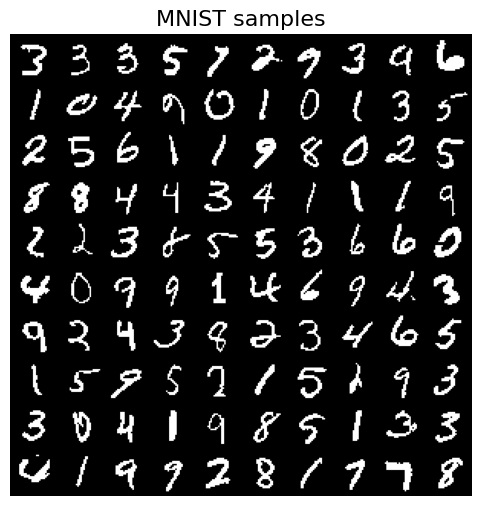

In [3]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data, "MNIST samples")

Please note that our data is discrete, and, moreover, it is binary.

In [4]:
np.unique(train_data)

array([0., 1.], dtype=float32)

In this task for the neural networks $s(\cdot)$ and $t(\cdot)$ we will use the ResNet-like network. The model will consist stack of Residual blocks:
$$
    \mathbf{y} = \mathbf{x} + f(\mathbf{x}).
$$

In [34]:
class ResnetBlock(nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.block(x)


class SimpleResnet(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, n_filters: int, n_blocks: int
    ) -> None:
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        ]
        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))
        layers.extend(
            [nn.ReLU(), nn.Conv2d(n_filters, out_channels, kernel_size=3, padding=1)]
        )
        self.resnet = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.resnet(x)

We have to implement coupling layer for images. To split image in two parts we will you checkerboard and chanelwise splitting (see image below).

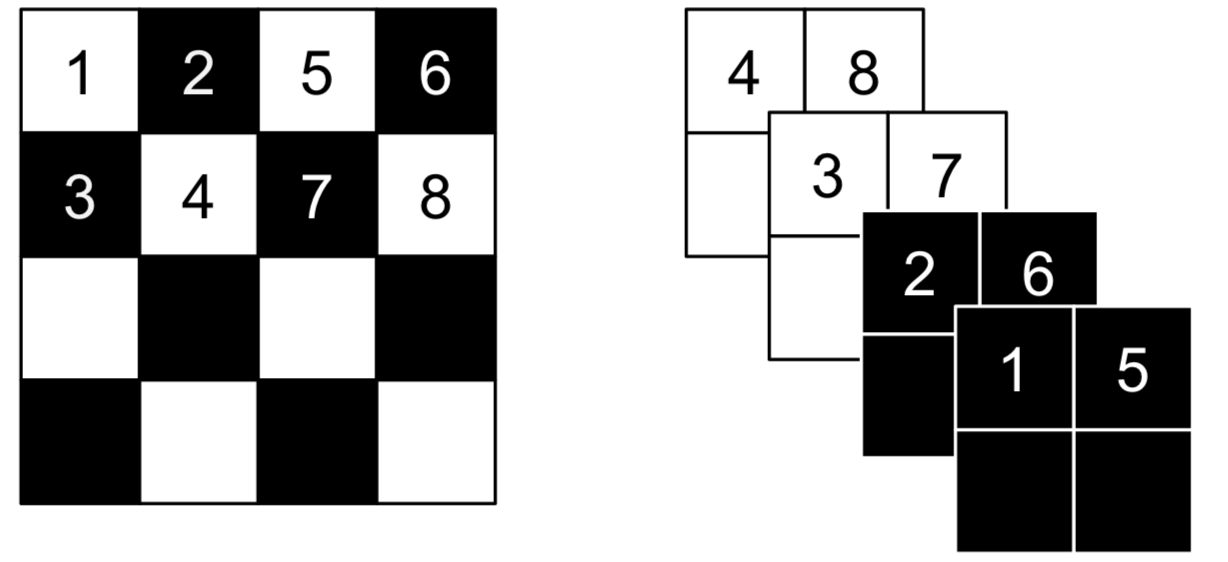

Firstly, let implement checkerboard splitting.

In [30]:
class AffineCheckerboardCouplingLayer(nn.Module):
    def __init__(
        self,
        parity_type: bool,
        input_shape: tuple,
        in_channels: int = 3,
        n_filters: int = 32,
        n_blocks: int = 4,
    ) -> None:
        assert isinstance(parity_type, bool)
        super().__init__()
        self.input_shape = input_shape
        self.parity_type = parity_type
        self.mask = self.build_mask()
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)

        # ====
        # your code
        # define resnet that will output s() and t()
        self.resnet = SimpleResnet(in_channels, 2*in_channels, n_filters, n_blocks)
        # ====

    @property
    def device(self):
        return next(self.parameters()).device

    def build_mask(self) -> torch.Tensor:
        # ====
        # your code
        # return checkerboard mask
        # if parity_type == True, the top left corner will be 1.0
        # if parity_type == False, the top left corner will be 0.0
        mask = torch.ones(1, 1, self.input_shape[0], self.input_shape[1])
        for i in range(self.input_shape[0]):
          for j in range(self.input_shape[1]):
            if self.parity_type:
              mask[0, 0, i, j] = (i + j + 1) % 2
            else:
              mask[0, 0, i, j] = (i + j) % 2
        # ====
        assert mask.shape[1:] == (1, *self.input_shape)
        return mask

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        batch_size = x.shape[0]
        n_channels = x.shape[1]
        mask = self.mask.repeat(batch_size, 1, 1, 1).to(self.device)

        # ====
        # your code
        # 1) mask tensor x
        # 2) apply resnet to masked x
        # 3) split resnet output to get s and t
        mask = self.mask.to(x.device)
        x_masked = x * mask
        s, t = self.resnet(x_masked).chunk(2, dim=1)
        # ====

        # this formula is described in Section 4.1 in original paper
        # just left it unchanged
        s = self.scale * torch.tanh(s) + self.scale_shift
        t = t * (1.0 - mask)
        s = s * (1.0 - mask)

        # ====
        # your code
        # apply forward (invert=False) or inverse (invert=True) transform
        if not invert:
            # Прямое преобразование
            z = x_masked + (1 - mask) * (x * torch.exp(s) + t)
            # s = s.sum(dim=[1, 2, 3])
        else:
            # Обратное преобразование
            z = x_masked + (1 - mask) * ((x - t) * torch.exp(-s))
            # s = -s.sum(dim=[1, 2, 3])
            s = -s
        # ====
        return z, s


def test_affine_checkerboard_coupling_layer():
    x = torch.zeros((1, 1, 2, 2), dtype=torch.float32)

    layer = AffineCheckerboardCouplingLayer(
        parity_type=True, input_shape=(2, 2), in_channels=1, n_filters=4, n_blocks=1
    )
    if USE_CUDA:
        x = x.cuda()
        layer = layer.cuda()
    mask = np.array([[1, 0], [0, 1]], dtype=np.float32)
    out1, out2 = layer(x)
    assert tuple(out1.size()) == (1, 1, 2, 2)
    assert tuple(out2.size()) == (1, 1, 2, 2)

    assert np.allclose(out1.cpu().detach().numpy()[0, 0] * mask, np.zeros((2, 2)))
    assert np.allclose(out2.cpu().detach().numpy()[0, 0], np.zeros((2, 2)))

    layer = AffineCheckerboardCouplingLayer(
        parity_type=False, input_shape=(2, 2), in_channels=1, n_filters=4, n_blocks=1
    )
    if USE_CUDA:
        layer = layer.cuda()
    mask = np.array([[0, 1], [1, 0]], dtype=np.float32)
    out1, out2 = layer(x)
    assert tuple(out1.size()) == (1, 1, 2, 2)
    assert tuple(out2.size()) == (1, 1, 2, 2)

    assert np.allclose(out1.cpu().detach().numpy()[0, 0] * mask, np.zeros((2, 2)))
    assert np.allclose(out2.cpu().detach().numpy()[0, 0], np.zeros((2, 2)))


test_affine_checkerboard_coupling_layer()

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): ResnetBlock(
    (block): Sequential(
      (0): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (3): ReLU()
  (4): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): ResnetBlock(
    (block): Sequential(
      (0): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (3): ReLU()
  (4): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


Secodly, let implement channelwise splitting.

In [44]:
class AffineChannelCouplingLayer(nn.Module):
    def __init__(
        self,
        parity_type: bool,
        in_channels: int = 6,
        n_filters: int = 32,
        n_blocks: int = 4,
    ) -> None:
        assert isinstance(parity_type, bool)
        super().__init__()
        self.parity_type = parity_type
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        # ====
        # your code
        # define resnet that will output s() and t()
        self.resnet = SimpleResnet(
            in_channels=in_channels,
            out_channels=in_channels  * 2,
            n_filters=n_filters,
            n_blocks=n_blocks,
        )
        # ====

    def forward(self, x: torch.Tensor, invert: bool = False) -> torch.Tensor:
        n_channels = x.shape[1]

        # ====
        # your code
        # 1) split x to two equal parts by channel dimension (dim=1)
        # 2) apply resnet to masked x
        # 3) split resnet output to get s and t
        x_split = x.chunk(2, dim=1)

        if self.parity_type:
            z_split, x_trans = x_split  # identity and transform branches
        else:
            x_trans, z_split = x_split

        st = self.resnet(z_split)
        s, t = st.chunk(2, dim=1)
        # ====

        # this formula is described in Section 4.1 in original paper
        # just left it unchanged
        s = self.scale * torch.tanh(s) + self.scale_shift

        # ====
        # your code
        # apply forward (invert=False) or inverse (invert=True) transform
        if not invert:
            z = x_trans * torch.exp(s) + t
        else:
            z = (x_trans - t) * torch.exp(-s)
        # ====

        # look carefully at this piece of code
        if self.parity_type:
            return torch.cat([z, z_split], dim=1), torch.cat(
                [s, torch.zeros_like(s)], dim=1
            )
        else:
            return torch.cat([z_split, z], dim=1), torch.cat(
                [torch.zeros_like(s), s], dim=1
            )


def test_affine_channel_coupling_layer():
    x = torch.zeros((1, 4, 2, 2), dtype=torch.float32)

    layer = AffineChannelCouplingLayer(
        parity_type=True, in_channels=2, n_filters=4, n_blocks=1
    )
    if USE_CUDA:
        x = x.cuda()
        layer = layer.cuda()

    mask = np.array(
        [[[0, 0], [0, 0]], [[0, 0], [0, 0]], [[1, 1], [1, 1]], [[1, 1], [1, 1]]],
        dtype=np.float32,
    )
    out1, out2 = layer(x)
    assert tuple(out1.size()) == (1, 4, 2, 2)
    assert tuple(out2.size()) == (1, 4, 2, 2)

    assert np.allclose(out1.cpu().detach().numpy()[0] * mask, np.zeros((4, 2, 2)))
    assert np.allclose(out2.cpu().detach().numpy()[0, 0], np.zeros((4, 2, 2)))

    layer = AffineChannelCouplingLayer(
        parity_type=False, in_channels=2, n_filters=4, n_blocks=1
    )
    if USE_CUDA:
        layer = layer.cuda()

    mask = np.array(
        [[[1, 1], [1, 1]], [[1, 1], [1, 1]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]],
        dtype=np.float32,
    )
    out1, out2 = layer(x)
    assert tuple(out1.size()) == (1, 4, 2, 2)
    assert tuple(out2.size()) == (1, 4, 2, 2)

    assert np.allclose(out1.cpu().detach().numpy()[0, 0] * mask, np.zeros((4, 2, 2)))
    assert np.allclose(out2.cpu().detach().numpy()[0, 0], np.zeros((4, 2, 2)))


test_affine_channel_coupling_layer()

We will use the following normalization layer for more stable training. Look carefully at the class below (do not chage it).

In [8]:
class ActNormLayer(nn.Module):
    def __init__(self, n_channels: int) -> None:
        super().__init__()
        self.log_scale = nn.Parameter(
            torch.zeros(1, n_channels, 1, 1), requires_grad=True
        )
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False

    def forward(self, x: torch.Tensor, invert: bool = False) -> torch.Tensor:
        if invert:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = -torch.log(
                    torch.std(
                        x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1
                    ).reshape(1, self.n_channels, 1, 1)
                )
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

Our data is discrete and binary. The normalizing flow model works with continuous data (it is a requirement of CoV theorem).

Therefore, we have to convert our discrete data to continuous one. This process is called dequantization. We will address it later in course.

To dequantize the discrete variable $x \in \{0, 1, \dots, K - 1\}$ we add uniform noise to it:
$$
    y = x + u, \quad u \sim \text{Uniform}[0, 1].
$$

Then random variable $y \in [0, K]$ will be continuous and in fact similar to $x$.

Let implement simple function for such dequantization.

In [9]:
def dequantize(x: torch.Tensor, nbins: int = 256) -> torch.Tensor:
    return (
        x * (nbins - 1)
        + torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(x.device)
    ) / nbins


def test_dequantize():
    x = torch.tensor((0, 1, 2, 3)) / 256.0
    y = dequantize(x).cpu().detach().numpy()
    x = x.cpu().detach().numpy()
    assert y.min() >= 0.0
    assert y.max() <= 4 / 256.0
    assert (y[3] > y[2]) and (y[2] > y[1]) and (y[1] > y[0])
    assert (y[3] > x[3]) and (y[2] > x[2]) and (y[1] > x[1]) and (y[0] > x[0])


test_dequantize()

The second issue that we will address here is the boundedness of the image domain. It is more natural for the model to fit the data from the range $(-\infty, +\infty)$.

The most natural way to convert $(-\infty, +\infty)$ range to the $[0, 1]$ is to apply sigmoid function. But here we need the inverse transform from [0, 1] range (it is normalized dequantized images) to $(-\infty, +\infty)$. So we need to apply inverse sigmoid function. This function is called logit:
$$
    \text{logit}(x) = \log \left( \frac{x}{1 - x} \right) = \log (x) - \log (1 - x).
$$

The last note here is the stability of this transform. To make it stable the common practice is to convert [0, 1] range to the $[\alpha, 1 - \alpha]$ firstly:
$$
    \text{logit}(x) = \log (y) - \log (1 - y), \quad \text{where } y = \alpha + (1 - 2 * \alpha) * x.
$$

Also we need the logarithm of the Jacobian' determinant for this transform. We implement this for you, but we really encourage you to check that the formula in the code is correct for better understanding.

In [10]:
class LogitTransform(nn.Module):
    def __init__(
        self, alpha: float = 0.05, dequantize: bool = True, nbins: int = 256
    ) -> None:
        super().__init__()
        self.alpha = alpha
        self.dequantize = dequantize
        self.nbins = nbins

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        if invert:
            log_det = (
                -x - 2 * F.softplus(-x) - torch.log(torch.tensor(1 - 2 * self.alpha))
            )
            x = (torch.sigmoid(x) - self.alpha) / (1 - 2 * self.alpha)
        else:
            # dequantization
            if self.dequantize:
                x = dequantize(x, nbins=self.nbins)

            # ====
            # your code
            # 1) scale the data to [alpha, 1 - alpha range] (save the result to x_scaled)
            # 2) apply logit operation that described above (save the result to x)
            x_scaled = x * (1 - 2 * self.alpha) + self.alpha  # [0.0, 0.9]
            x = torch.log(x_scaled) - torch.log(1.0 - x_scaled)
            # ====

            # look carefully at this expression, try to understand this formula
            log_det = (
                -torch.log(x_scaled)
                - torch.log(1.0 - x_scaled)
                + torch.log(torch.tensor(1 - 2 * self.alpha))
            )
        return x, log_det


def test_logit_transform():
    layer = LogitTransform(dequantize=False)
    x = torch.tensor((0, 1, 2, 3)) / 256.0
    z, log_det = layer(x)
    assert np.allclose(
        z.cpu().detach().numpy(),
        np.array([-2.944439, -2.8727808, -2.8054335, -2.7418802]),
    )
    assert np.allclose(
        log_det.cpu().detach().numpy(),
        np.array([2.9416652, 2.8774219, 2.8175175, 2.7614343]),
    )

    x_restored, log_det2 = layer(z, invert=True)
    assert np.allclose(x.cpu().detach().numpy(), x_restored.cpu().detach().numpy())


test_logit_transform()

Now it is time to define the final model.

The model will consist of several blocks:

1. Logit Transform (to convert the data to $(-\infty, \infty)$ range).
2. Stack of checkerboard coupling layers.
3. Squeeze operation (convert tensor $[B, C, H, W]$ to $[B, 4 * C, H / 2, W / 2]$).
4. Stack of channelwise coupling layers
5. Unsqueeze operation (convert tensor $[B, C, H, W]$ to $[B, C / 4, 2 * H, 2 * W]$).
2. Stack of checkerboard coupling layers.

In [55]:
class RealNVP(nn.Module):
    def __init__(self, input_shape: tuple, n_channels: int, n_filters: int, n_blocks: int, nbins:int = 256) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.n_channels = n_channels
        self.nbins = nbins

        self.prior = torch.distributions.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))
        self.logit_transform = LogitTransform(nbins=nbins, dequantize=True)

        # ====
        # your code
        # define stack of checkerboard coupling layers with alternating parity_type
        # add ActNormLayer after each coupling layer
        self.transforms1 = nn.ModuleList()
        for i in range(4):  # 4 checkerboard coupling layers
            self.transforms1.append(ActNormLayer(n_channels))
            self.transforms1.append(AffineCheckerboardCouplingLayer(
                input_shape=input_shape,
                in_channels=n_channels,
                n_filters=n_filters,
                parity_type=(i % 2 == 0),
                n_blocks=n_blocks
            ))
        # ====

        # ====
        # your code
        # define stack of channel coupling layers with alternating parity_type
        # add ActNormLayer after each coupling layer
        self.transforms2 = nn.ModuleList()
        squeezed_channels = n_channels * 2
        for i in range(4):  # 4 channel coupling layers  # After squeeze
            self.transforms2.append(AffineChannelCouplingLayer(
                parity_type=(i % 2 == 0),
                in_channels=squeezed_channels,
                n_filters=n_filters,
                n_blocks=n_blocks
            ))
            self.transforms2.append(ActNormLayer(n_channels * 4))
        # ====

        # ====
        # your code
        # define stack of checkerboard coupling layers with alternating parity_type
        # add ActNormLayer after each coupling layer
        self.transforms3 = nn.ModuleList()
        for i in range(4):  # 4 checkerboard coupling layers
            self.transforms3.append(ActNormLayer(n_channels))
            self.transforms3.append(AffineCheckerboardCouplingLayer(
                input_shape=input_shape,
                in_channels=n_channels,
                n_filters=n_filters,
                parity_type=(i % 2 == 0),
                n_blocks=n_blocks
            ))
        # ====

    @property
    def device(self):
        return next(self.parameters()).device

    def squeeze(self, x: torch.Tensor) -> torch.Tensor:
        # Look carefully at this piece of code (do not change)
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x

    def undo_squeeze(self, x: torch.Tensor) -> torch.Tensor:
        # Look carefully at this piece of code (do not change)
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        z = x
        log_det = torch.zeros_like(x)
        if invert:
            for op in reversed(self.transforms3):
                z, delta_log_det = op.forward(z, invert=True)
                log_det += delta_log_det
            z, log_det = self.squeeze(z), self.squeeze(log_det)
            for op in reversed(self.transforms2):
                z, delta_log_det = op.forward(z, invert=True)
                log_det += delta_log_det
            z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
            for op in reversed(self.transforms1):
                z, delta_log_det = op.forward(z, invert=True)
                log_det += delta_log_det
            z, delta_log_det = self.logit_transform(z, invert=True)
            log_det += delta_log_det
        else:
            z, delta_log_det = self.logit_transform(z)
            log_det += delta_log_det
            for op in self.transforms1:
                z, delta_log_det = op.forward(z)
                log_det += delta_log_det
            z, log_det = self.squeeze(z), self.squeeze(log_det)
            for op in self.transforms2:
                z, delta_log_det = op.forward(z)
                log_det += delta_log_det
            z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
            for op in self.transforms3:
                z, delta_log_det = op.forward(z)
                log_det += delta_log_det
        return z, log_det

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        self.prior.loc = self.prior.loc.to(self.device)
        self.prior.scale = self.prior.scale.to(self.device)
        # ====
        # your code
        # 1) make forward pass with right inverse flag
        # 2) sum log_det with log of base distribution (log p(z))
        # 3) we will get tensor of shape [batch_size, 3, H, W] - sum it over the the last 3 dimensions
        z, log_det = self.forward(x)
        log_prob_z = self.prior.log_prob(z)
        log_prob_x = log_prob_z.sum(dim=[1, 2, 3]) + log_det.sum(dim=[1, 2, 3])
        # ====
        return log_prob_x

    def loss(self, x: torch.Tensor) -> dict:
        return {'nll_loss': -self.log_prob(x).mean()}

    def sample(self, num_samples: int) -> np.ndarray:
        self.prior.loc = self.prior.loc.to(self.device)
        self.prior.scale = self.prior.scale.to(self.device)
        # Look carefully at this piece of code (do not change)
        z = self.prior.sample([num_samples, self.n_channels, *self.input_shape])
        samples = self.forward(z, invert=True)[0]
        samples = samples.cpu().detach().numpy()
        samples = np.floor(np.clip(samples * self.nbins, 0.0, self.nbins - 1)) / (self.nbins - 1)
        return samples

Let train this model :)

In our case it took about 30-60 minutes to get appropriate samples.

  0%|          | 0/20 [00:00<?, ?it/s]

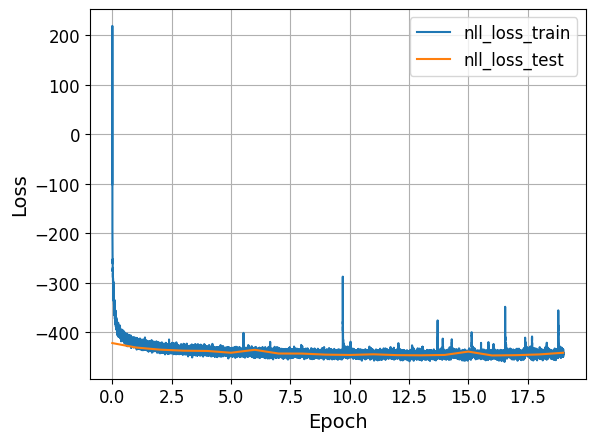

In [60]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 32   # any adequate value
LR = 1e-3          # <= 1e-3
EPOCHS = 20      # <= 20
N_FILTERS = 64   # < 128
N_BLOCKS = 4    # < 8
# ====

loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = data.DataLoader(train_data, **loader_args)
test_loader = data.DataLoader(test_data, **loader_args)

# model
model = RealNVP(
    input_shape=(28, 28), n_channels=1, n_filters=N_FILTERS, n_blocks=N_BLOCKS, nbins=2
)

# train
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key="nll_loss",
    use_cuda=USE_CUDA,
    use_tqdm=True,
)
plot_training_curves(train_losses, test_losses)

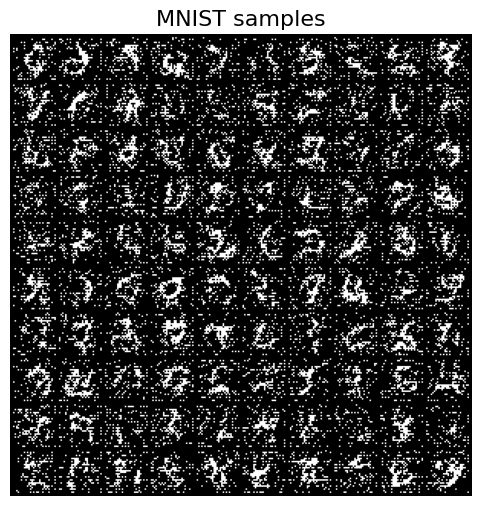

In [61]:
samples = model.sample(100)
show_samples(samples, "MNIST samples")